In [1]:
!pip install optuna

In [2]:
!pip install  monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:0000:0100:01


In [3]:
!pip install transformers

In [4]:
#librarires to be installed
import os,sys
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
from albumentations import *

In [5]:
#all required torch libraries
import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms,utils
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.ops import masks_to_boxes

In [6]:
import time
import optuna
import csv
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("finished")
from os import listdir
from os.path import isfile, join

finished


In [7]:
import monai
from torchvision.ops import masks_to_boxes

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [8]:
def resize(path):
  dirs = os.listdir( path )
  for item in tqdm(dirs):
    if os.path.isfile(path+item):
      im = Image.open(path+item)
      f, e = os.path.splitext(path+item)
      imResize = im.resize((256,256), Image.NEAREST)
      imResize.save(f+e, 'PNG', quality=100)
      
label_path =  "/kaggle/input/nucleus-data/nucleus_data/segmentation_maps"
output_features_path = "/kaggle/input/nucleus-data/nucleus_data/features"
resize(label_path)



  0%|          | 0/6790 [00:00<?, ?it/s]

In [9]:
ids=[]
label_filenames = [f for f in listdir(label_path) if isfile(join(label_path, f))]
feature_filenames = [f for f in listdir(output_features_path) if isfile(join(output_features_path, f))]
for i in range(len(feature_filenames)):
  ids.append(feature_filenames[i][1:])
print(len(ids))

df = pd.DataFrame(ids ,columns=["file_ids"])
df.to_csv('file_ids.csv', index=False)

#sanity check
df = pd.read_csv('file_ids.csv')
df.head()

6756


,file_ids
0,182_22.png
1,167_27.png
2,86_29.png
3,154_16.png
4,177_8.png


In [10]:
# # def get_bboxes(mask_path):
# #     mask = cv2.imread(mask_path, cv2.IMREAD_ANYDEPTH)
# #     mask = mask.astype(np.uint8)
# #     mask = torch.as_tensor(mask)
# #     obj_ids = torch.unique(mask)
# #     obj_ids = obj_ids[1:]
# #     masks = mask == obj_ids[:, None, None]
# #     boxes = masks_to_boxes(masks)
# #     print(boxes)

#  mask = self.transform_label(mask)
#         mask = mask.float()
#         return self.transform_image(image), mask

In [11]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch

class segmentationDataset(Dataset):
    def __init__(self, csv, augmentation=None, transform_image=None, transform_label=None):
        self.df = pd.read_csv(csv)
        self.ids = self.df["file_ids"]
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augmentation = augmentation

    def __getitem__(self, idx):
        image = np.array(Image.open("/kaggle/input/nucleus-data/nucleus_data/features/F" + self.ids[idx]))
        mask = np.array(Image.open("/kaggle/input/nucleus-data/nucleus_data/segmentation_maps/L" + self.ids[idx]))

        if self.augmentation is not None:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        image = self.transform_image(image)
        mask = self.transform_label(mask)

        b_boxes = self.masks_to_boxes(mask)

        return image.float(), mask.float(), b_boxes.float()

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def masks_to_boxes(mask):
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]  # Exclude background (0) label
        b_boxes = []
        for obj_id in obj_ids:
            obj_mask = mask == obj_id
            pos = torch.where(obj_mask)
            x_min = torch.min(pos[1])
            x_max = torch.max(pos[1])
            y_min = torch.min(pos[0])
            y_max = torch.max(pos[0])
            b_box = torch.tensor([x_min, y_min, x_max, y_max])
            b_boxes.append(b_box)
        if b_boxes:
            b_boxes = torch.stack(b_boxes)
        else:
            b_boxes = torch.empty(0, 4)
        return b_boxes


def collate_fn(batch):
    images = []
    masks = []
    b_boxes_list = []

    for image, mask, b_boxes in batch:
        images.append(image)
        masks.append(mask)
        b_boxes_list.append(b_boxes)

    max_num_b_boxes = max(len(b_boxes) for b_boxes in b_boxes_list)

    padded_b_boxes = []
    for b_boxes in b_boxes_list:
        padded_b_boxes.append(torch.cat([b_boxes, torch.zeros(max_num_b_boxes - len(b_boxes), 4)]))

    return torch.stack(images), torch.stack(masks), torch.stack(padded_b_boxes)


In [12]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
     

In [13]:
full_dataset = segmentationDataset(csv = "file_ids.csv",
                                    augmentation =  Compose([
                                                            #GridDistortion(p=0.5),
                                                            Transpose(p=0.5),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            ShiftScaleRotate(p=0.1),
                                                            OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=1),
                                                            ]),

                                    transform_image = transforms.Compose([ 
                                                                    
                                                                    transforms.ToPILImage(),
                                                                    ToTensor(),
                                                                    transforms.RandomApply([AddGaussianNoise( mean = 0.5,std= 0.05)], p=0.5)
                                                                ]),                                  
                                    transform_label = transforms.Compose([ 
                                                                                                      
                                                                    transforms.ToPILImage(),
                                                                    ToTensor(),

                                                                ]))


In [14]:
train_batch_size = 16
train_size = int(0.8* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(dataset=test_dataset, batch_size= 4, shuffle = True,collate_fn=collate_fn)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")


for image,mask,boxes in train_loader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{image.shape=}, {mask.shape=},{boxes.shape=}")
    print(boxes.shape)
    break
    


676 batches 
338  batches 
image.shape=torch.Size([8, 3, 1024, 1024]), mask.shape=torch.Size([8, 1, 256, 256]),boxes.shape=torch.Size([8, 118, 4])
torch.Size([8, 118, 4])


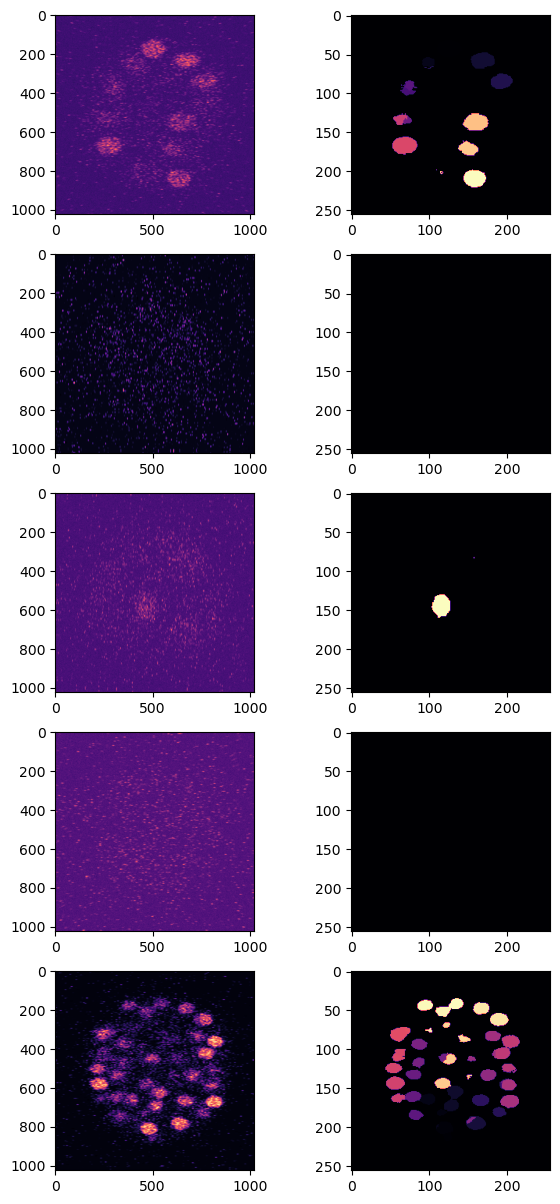

In [15]:
batch  = next(iter(train_loader))
images, masks,boxes = batch
fig, ax = plt.subplots(5, 2, figsize = (7,15))
for i in range(5):
    ax[i][0].imshow(images[i][0], cmap='magma')
    ax[i][1].imshow(masks[i][0], cmap='magma')

In [16]:
#image shape
batch[0].shape


torch.Size([8, 3, 1024, 1024])

In [17]:
batch[1].shape

torch.Size([8, 1, 256, 256])

In [18]:
batch[2].shape

torch.Size([8, 49, 4])

In [19]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-06-26 10:52:30--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.2.6, 13.224.2.21, 13.224.2.42, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.2.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   241MB/s    in 1.5s    

2023-06-26 10:52:32 (241 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [20]:
from segment_anything import SamPredictor, sam_model_registry
work_dir = '/kaggle/working/'
task_name = 'cell_segmentor'
model_type = 'vit_b'
checkpoint = '/kaggle/working/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [21]:
for name, param in sam_model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [22]:

from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


In [23]:
num_epochs = 100
losses = []
best_loss = 1e10

In [25]:
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image, masks, boxes) in enumerate(tqdm(train_loader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            embedding = sam_model.image_encoder(image)
            img_embeddings.append(embedding.cpu().numpy()[0])
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))

  0%|          | 0/676 [00:00<?, ?it/s]

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor